# **-Dependencias y archivos para que funcione el modelo**

In [1]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

# Instalamos las dependencias con la versión optimizada de xformers
!pip install httpx --upgrade
!pip install langsmith --upgrade
!pip install openai --upgrade
!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2


# Descargamos el modelo usando aria2 para descargarlo rapidamente
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors
!pip install googletrans==4.0.0-rc1 --use-deprecated=legacy-resolver


#Importamos las librerias que vamos a usar
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from googletrans import Translator

# Inicializa el traductor
translator = Translator()


# Cargamos las clases de node que vamos a usar
DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

# Habilitamos las optimizaciones de rendimiento de PyTorch
torch.set_float32_matmul_precision('high')
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)

# Cargamos los modelos con inference_mode y compilación potencial para mayor velocidad.
with torch.inference_mode(), torch.autocast("cuda"):
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    # Compilamos el modelo CLIP para una posible aceleración (si es compatible)
    try:
        clip = torch.compile(clip, mode="reduce-overhead", fullgraph=True)
    except Exception as e:
        print(f"Peligro: No se pudo compilar el modelo CLIP: {e}")

    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    # Compilamos el modelo UNET
    try:
        unet = torch.compile(unet, mode="reduce-overhead")
    except Exception as e:
        print(f"Peligro: No se pudo compilar el modelo CLIP: {e}")

    vae = VAELoader.load_vae("ae.sft")[0]


def closestNumber(n, m):

   return (n // m) * m

/content
fatal: destination path '/content/TotoroUI' already exists and is not an empty directory.
/content/TotoroUI
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
8df175|OK  |       0B/s|/content/TotoroUI/models/unet/flux1-dev-fp8.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
71c456|OK  |       0B/s|/content/TotoroUI/models/vae/ae.sft

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
8db53a|OK  |       0B/s|/content/TotoroUI/models/clip/clip_l.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg spee

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Peligro: No se pudo compilar el modelo CLIP: 
Peligro: No se pudo compilar el modelo CLIP: 


# **-Funcion para convertir de texto a imagen**

In [2]:
def textoimagen():
  with torch.inference_mode():
      positive_prompt = translation.text
      width = 512                         #tamaño de la imagen
      height = 512
      seed = 0                            #Seed para generar la imagen
      steps = 10                          #Pasos para asegurar que la imagen sea de buena calidad
      sampler_name = "euler"              #Usamos el muestreador Euler
      scheduler = "simple"                #Usamos un programador basico para reducir el ruido en la imagen

      if seed == 0:
          seed = random.randint(0, 18446744073709551615)
      #print(seed)  #esto es para ver que seeds salian al generar una imagen

      cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True) #Esta linea utiliza el modelo CLIP para procesar el positive_prompt
      cond = [[cond, {"pooled_output": pooled}]]                                                 #clip.tokenize divide el texto en tokens luego se obtienen dos salidas: cond y pooled
      noise = RandomNoise.get_noise(seed)[0]                                                     #aqui se genera un tensor de ruido aleatorio con la seed para empezar a generar la imagen
      guider = BasicGuider.get_guider(unet, cond)[0]                                             #aqui se genera una guía que ayudara a dirigir el proceso de generación de la imagen para que se ajuste a la descripcion
      sampler = KSamplerSelect.get_sampler(sampler_name)[0]                                      #aqui el muestreador define la estrategia para refinar la imagen durante la generación
      sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]                         #aqui los sigmas controlan la cantidad de ruido que se agrega o elimina en cada paso de la generacion
      latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]      #aqui se crea una imagen latente vacía  con las dimensiones especificadas por width y height
      sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)  #esta es la linea principal donde se realiza la generacion de la imagen
      model_management.soft_empty_cache()                                                             #aqui se libera memoria de cache de los modelos para evitar problemas de memoria
      decoded = VAEDecode.decode(vae, sample)[0].detach()                                             #aqui la imagen latente se decodifica utilizando el VAE para obtener una imagen real (decoded)
      Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/ImagenGenerada.png")   #la imagen decodificada (decoded) se convierte a una imagen PIL y se guarda en la ruta establecida

  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])                                           #Se devuelve la imagen PIL generada.
  return Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

# **-Funcion para separar los textos largos**

In [3]:
def split_text_large_input(text,                 # Texto largo a separar
                          max_chunk_length=150,  # Máximo de caracteres por chunk
                          split_method="smart",  # Opciones: "sentence", "paragraph", "fixed"
                          overlap_sentences=1):  # Solapamiento entre chunks

    # Preprocesamiento: eliminar espacios extras y saltos de línea múltiples
    text = re.sub(r'\s+', ' ', text.strip())

    # Método 1: Dividir por oraciones naturales
    if split_method == "sentence":
        sentences = sent_tokenize(text)
        chunks = []
        current_chunk = []
        current_length = 0

        for sentence in sentences:
            if current_length + len(sentence) <= max_chunk_length or not current_chunk:
                current_chunk.append(sentence)
                current_length += len(sentence)
            else:
                chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_length = len(sentence)

        if current_chunk:
            chunks.append(" ".join(current_chunk))

    # Método 2: Dividir por párrafos (doble salto de línea)
    elif split_method == "paragraph":
        paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
        chunks = []
        for para in paragraphs:
            if len(para) > max_chunk_length:
                chunks.extend(split_text_large_input(para, max_chunk_length, "sentence"))
            else:
                chunks.append(para)

    # Método 3: División fija por longitud
    elif split_method == "fixed":
        chunks = [text[i:i+max_chunk_length] for i in range(0, len(text), max_chunk_length)]

    # Método "smart": Combina párrafos y oraciones
    else:
        paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
        chunks = []
        for para in paragraphs:
            if len(para) <= max_chunk_length:
                chunks.append(para)
            else:
                sentences = sent_tokenize(para)
                current_chunk = []
                current_length = 0
                for sentence in sentences:
                    if current_length + len(sentence) <= max_chunk_length or not current_chunk:
                        current_chunk.append(sentence)
                        current_length += len(sentence)
                    else:
                        chunks.append(" ".join(current_chunk))
                        current_chunk = [sentence]
                        current_length = len(sentence)
                if current_chunk:
                    chunks.append(" ".join(current_chunk))

    return chunks


# **-Introducir texto para probar el funcionamiento**

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Ingrese un texto para generar una imagen: Violet Sorrengail creía que se uniría al Cuadrante de los Escribas para vivir una vida tranquila, sin embargo, por órdenes de su madre, debe unirse a los miles de candidatos que, en el Colegio de Guerra de Basgiath, luchan por formar parte de la élite de Navarre: el Cuadrante de los Jinetes de dragón.  Cuando eres más pequeña y frágil que los demás tu vida corre peligro, porque los dragones no se vinculan con humanos débiles. Además, con más jinetes que dragones disponibles, muchos la matarían con tal de mejorar sus probabilidades de éxito; y hay otros, como el despiadado Xaden Riorson, el líder de ala más poderoso del Cuadrante de Jinetes, que la asesinarían simplemente por ser la hija de la comandante general. Para sobrevivir, necesitará aprovechar al máximo todo su ingenio. Mientras  la guerra se torna más letal Violet sospecha que los líderes de Navarre esconden un terrible secreto...

=== Chunk 1 ===
Violet Sorrengail believed that he woul

  0%|          | 0/10 [00:00<?, ?it/s]

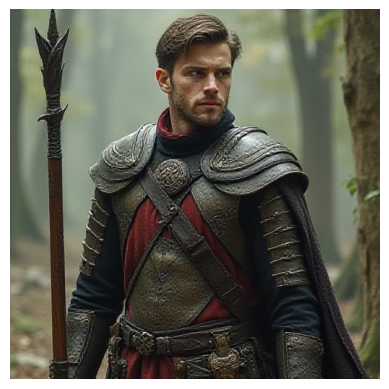


=== Chunk 2 ===
When you are smaller and fragile than others your life is in danger, because dragons are not linked to weak humans.
Longitud: 115 caracteres


  0%|          | 0/10 [00:00<?, ?it/s]

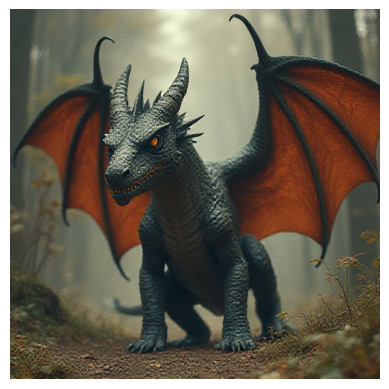


=== Chunk 3 ===
In addition, with more riders than available dragons, many would kill her in order to improve her chances of success;And there are others, such as the ruthless Xaden Riorson, the most powerful wing leader of the rider of riders, who would simply murder her for being the daughter of the general commander.
Longitud: 305 caracteres


  0%|          | 0/10 [00:00<?, ?it/s]

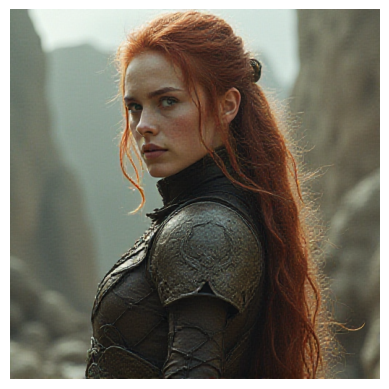


=== Chunk 4 ===
To survive, you will need to make the most of your wit.
Longitud: 55 caracteres


  0%|          | 0/10 [00:00<?, ?it/s]

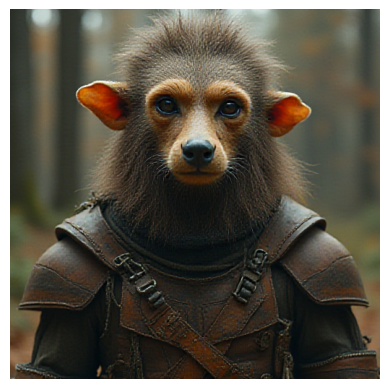


=== Chunk 5 ===
While the war becomes more lethal Violet suspects that Navarre leaders hide a terrible secret ...
Longitud: 97 caracteres


  0%|          | 0/10 [00:00<?, ?it/s]

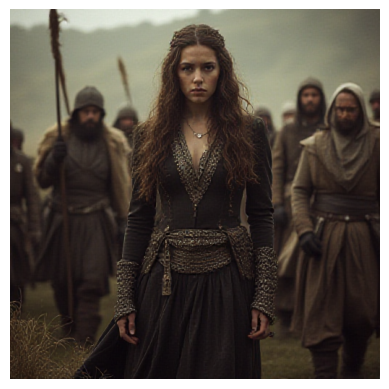

In [5]:
import nltk

# Download the 'punkt_tab' dataset
nltk.download('punkt_tab')

chunks = split_text_large_input(input("Ingrese un texto para generar una imagen: "),
                               max_chunk_length=150,
                               split_method="smart",
                               overlap_sentences=1)
#Mostrar los chunks
for i, chunk in enumerate(chunks, 1):
    print(f"\n=== Chunk {i} ===")
    #print(chunk)
    translation = translator.translate(chunk, src='es', dest='en')
    print(translation.text)
    print(f"Longitud: {len(translation.text)} caracteres")
    textoimagen()
    # Cargar la imagen desde la ruta
    image_path = "/content/ImagenGenerada.png"
    image = mpimg.imread(image_path)
    # Mostrar la imagen
    plt.imshow(image)
    plt.axis('off')  # Ocultar ejes
    plt.show()
